<a href="https://colab.research.google.com/github/CcgAlberta/pygeostat/blob/master/examples/Kriging1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pygeostat as gs
import numpy as np
import os
import pandas as pd
from matplotlib import pyplot as plt

# Settings

In [ ]:
outdir = 'Output'
gs.mkdir(outdir)
#path to GSLIB executables
exe_dir="../pygeostat/executable/"

gs.PlotStyle['font.size'] = 12
gs.Parameters['data.tmin'] = -998

# Loading data

In [ ]:
dfl = gs.ExampleData('point2d_mv')
dfl.head()

,X,Y,Var1,Var2,Var3
0,28949.708226,96548.685172,0.78641,2.96716,-1.47010
1,24610.158555,96251.877101,0.54300,2.13614,0.74573
2,27719.964681,90687.703337,-0.39320,0.48682,0.23470
3,26910.320345,92501.863566,0.44938,1.27002,-0.31840
4,21725.601294,92981.211253,1.38558,1.77734,2.40020


In [ ]:
dfl.info

DataFile: C:\Users\yimin\Anaconda3\envs\pygeostat\lib\site-packages\pygeostat\data\example_data\point2d_mv.dat
Attributes:
x: 'X',  y: 'Y',  
Variables:
'Var1', 'Var2', 'Var3'


# Data Visualizations

## Distibution

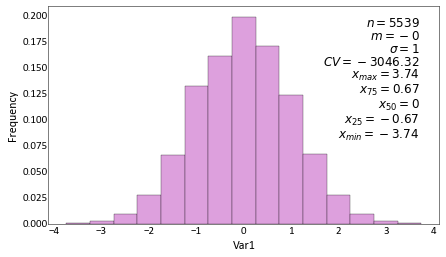

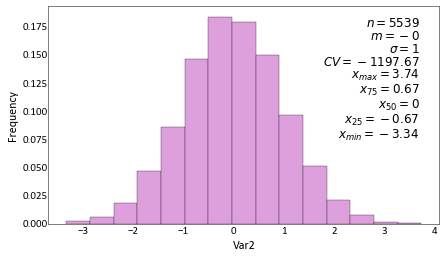

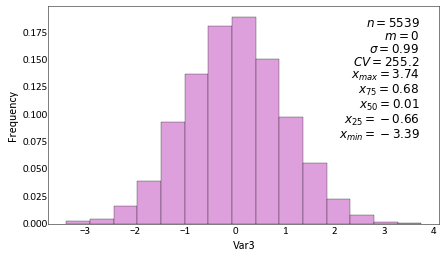

In [ ]:
for var in dfl.variables:
    gs.histogram_plot(dfl, var=var, figsize = (7,4), color='plum')

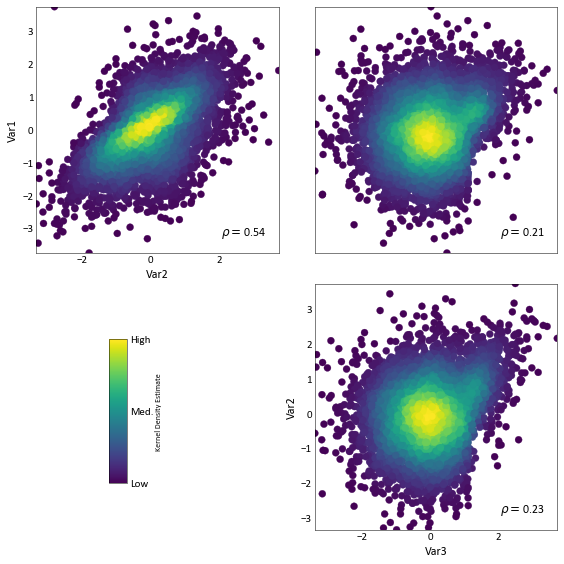

In [ ]:
_ = gs.scatter_plots(dfl)

## Location map

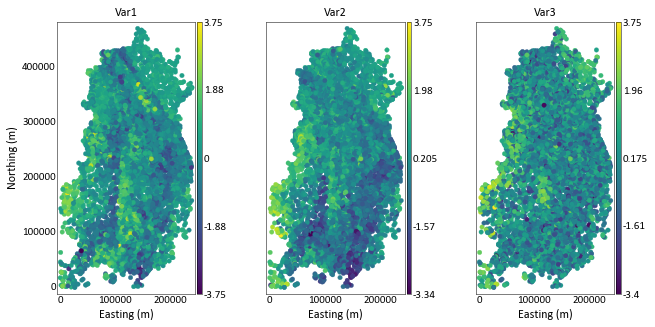

In [ ]:
fig, axes = gs.subplots(1, len(dfl.variables), axes_pad=(0.9, 0.4), figsize= (25,5), cbar_mode='each', label_mode='L')
for i, var in enumerate(dfl.variables):
    gs.location_plot(dfl, var = var, ax = axes[i])

# Variogram Calculation and Modeling

Experimental variogram is claulated and modeled for the first variable

In [ ]:
dfl.spacing(n_nearest=5)
dfl.head()

,X,Y,Var1,Var2,Var3,Data Spacing (m)
0,28949.708226,96548.685172,0.78641,2.96716,-1.47010,5313.903775
1,24610.158555,96251.877101,0.54300,2.13614,0.74573,3989.836067
2,27719.964681,90687.703337,-0.39320,0.48682,0.23470,5051.373369
3,26910.320345,92501.863566,0.44938,1.27002,-0.31840,3929.811601
4,21725.601294,92981.211253,1.38558,1.77734,2.40020,4054.581266


## Horizonal variogram parameters

In [ ]:
lag_length_h = dfl['Data Spacing (m)'].values.mean()
print('average data spacing in XY plane: {:.3f} {}'.format(lag_length_h,
                                                           gs.Parameters['plotting.unit']))

average data spacing in XY plane: 3540.358 m


In [ ]:
x_range = np.ptp(dfl[dfl.x].values)
y_range = np.ptp(dfl[dfl.y].values)
n_lag_x =  (x_range * 0.5) /  lag_length_h
n_lag_y =  (y_range * 0.5) /  lag_length_h
lag_tol_h = lag_length_h * 0.6

In [ ]:
var_calc = gs.Program(program=exe_dir+'varcalc')

In [ ]:
parstr = """      Parameters for VARCALC
                  **********************
 
START OF PARAMETERS:
{file}                             -file with data
1 2 0                              -   columns for X, Y, Z coordinates
1 3                                -   number of variables,column numbers (position used for tail,head variables below)
{t_min}    1.0e21                   -   trimming limits
{n_directions}                                  -number of directions
0.0 15 1000 0.0 22.5 1000 0.0   -Dir 01: azm,azmtol,bandhorz,dip,diptol,bandvert,tilt
 {n_lag_y}  {lag_length_h}  {lag_tol_h}            -        number of lags,lag distance,lag tolerance
90.0 15 1000 0.0 22.5 1000 0.0   -Dir 02: azm,azmtol,bandhorz,dip,diptol,bandvert,tilt
 {n_lag_x}  {lag_length_h}  {lag_tol_h}                 -        number of lags,lag distance,lag tolerance
{output}                          -file for experimental variogram points output.
0                                 -legacy output (0=no, 1=write out gamv2004 format)
1                                 -run checks for common errors
1                                 -standardize sills? (0=no, 1=yes)
1                                 -number of variogram types
1   1   1   1                     -tail variable, head variable, variogram type (and cutoff/category), sill
"""

n_directions = 2
varcalc_outfl = os.path.join(outdir, 'varcalc.out')

var_calc.run(parstr=parstr.format(file=dfl.flname,
                                  n_directions = n_directions,
                                  t_min = gs.Parameters['data.tmin'],
                                  n_lag_x=n_lag_x,
                                  n_lag_y=n_lag_y,
                                  lag_length_h = lag_length_h,
                                  lag_tol_h = lag_tol_h,
                                  output=varcalc_outfl),
             liveoutput=True)

Calling:  ['../pygeostat/executable/varcalc', 'temp']

varcalc version:  1.400

  data file: 
 C:\Users\yimin\Anaconda3\envs\pygeostat\lib\site-packages\pygeostat\data\exampl
 e_data\point2d_mv.dat
  x,y,z columns:            1           2           0
  number of variables:            1
  Variable columns:            3
  tmin,tmax:   -998.000000000000       1.000000000000000E+021
  number of directions:            2
  direction parameters:
 azm,azmtol,bandhorz  0.000000000000000E+000   15.0000000000000     
   1000.00000000000     
 dip,diptol,bandvert  0.000000000000000E+000   22.5000000000000     
   1000.00000000000     
 tilt  0.000000000000000E+000
 nlags,lagdist,lagtol          66   3540.35845705671     
   2124.21507423402     
 azm,azmtol,bandhorz   90.0000000000000        15.0000000000000     
   1000.00000000000     
 dip,diptol,bandvert  0.000000000000000E+000   22.5000000000000     
   1000.00000000000     
 tilt  0.000000000000000E+000
 nlags,lagdist,lagtol          33   3

In [ ]:
varfl = gs.DataFile(varcalc_outfl)
varfl.head()

,Variogram Index,Lag Distance,Number of Pairs,Variogram Value,Variogram Number,Calculation Azimuth,Calculation Dip,Variogram Type,Variogram Tail Index,Variogram Head Index
0,1.0,1356.675118,468.0,0.310738,1.0,0.0,0.0,1.0,1.0,1.0
1,1.0,3873.560972,3070.0,0.438385,1.0,0.0,0.0,1.0,1.0,1.0
2,1.0,7071.060717,3893.0,0.490704,1.0,0.0,0.0,1.0,1.0,1.0
3,1.0,10611.610525,3662.0,0.574807,1.0,0.0,0.0,1.0,1.0,1.0
4,1.0,14141.319963,3558.0,0.656667,1.0,0.0,0.0,1.0,1.0,1.0


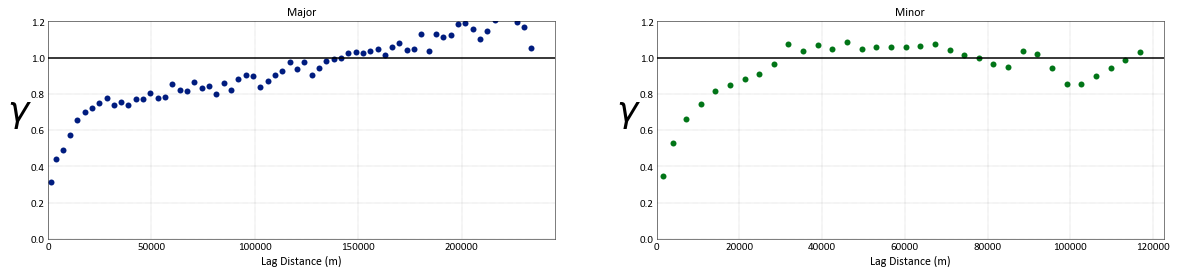

In [ ]:
colors = gs.get_palette('cat_dark', n_directions, cmap=False)
titles = ['Major', 'Minor']
fig, axes = plt.subplots(1, n_directions, figsize= (20,4))
for i in range(n_directions):
    gs.variogram_plot(varfl, index=i+1, ax = axes[i], color=colors[i], title = titles[i], grid=True)

In [ ]:
var_model = gs.Program(program=exe_dir+'varmodel')

In [ ]:
parstr = """      Parameters for VARMODEL
                  ***********************
 
START OF PARAMETERS:
{varmodel_outfl}             -file for modeled variogram points output
{n_directions}                             -number of directions to model points along
0.0   0.0  {n_lag_y}  {lag_length_h}         -  azm, dip, npoints, point separation
90.0   0.0  {n_lag_x}  {lag_length_h}      -  azm, dip, npoints, point separation
2    0.0                   -nst, nugget effect
1    ?    0.0   0.0   0.0    -it,cc,azm,dip,tilt (ang1,ang2,ang3)
        ?     ?     ?    -a_hmax, a_hmin, a_vert (ranges)
1    ?    0.0   0.0   0.0    -it,cc,azm,dip,tilt (ang1,ang2,ang3)
        ?     ?     ?    -a_hmax, a_hmin, a_vert (ranges)
1   100000                   -fit model (0=no, 1=yes), maximum iterations
1.0                          -  variogram sill (can be fit, but not recommended in most cases)
1                            -  number of experimental files to use
{varcalc_outfl}              -    experimental output file 1
3 1 2 3                    -      # of variograms (<=0 for all), variogram #s
1   0   10                   -  # pairs weighting, inverse distance weighting, min pairs
0     10.0                   -  fix Hmax/Vert anis. (0=no, 1=yes)
0      1.0                   -  fix Hmin/Hmax anis. (0=no, 1=yes)
{varmodelfit_outfl}          -  file to save fit variogram model
"""

varmodel_outfl = os.path.join(outdir, 'varmodel.out')
varmodelfit_outfl = os.path.join(outdir, 'varmodelfit.out')

var_model.run(parstr=parstr.format(varmodel_outfl= varmodel_outfl,
                                   n_directions = n_directions,
                                   n_lag_x= n_lag_x*2,
                                   n_lag_y = n_lag_y*2,
                                   lag_length_h = lag_length_h/2,
                                   varmodelfit_outfl = varmodelfit_outfl,
                                   varcalc_outfl = varcalc_outfl), liveoutput=False, quiet=True)


In [ ]:
varmdl = gs.DataFile(varmodel_outfl)
varmdl.head()

,Variogram Index,Lag Distance,Number of Pairs,Variogram Value,Variogram Number,Calculation Azimuth,Calculation Dip
0,1.0,1770.179229,1.0,0.165519,1.0,0.0,0.0
1,1.0,3540.358457,1.0,0.321222,1.0,0.0,0.0
2,1.0,5310.537686,1.0,0.457293,1.0,0.0,0.0
3,1.0,7080.716914,1.0,0.563914,1.0,0.0,0.0
4,1.0,8850.896143,1.0,0.631269,1.0,0.0,0.0


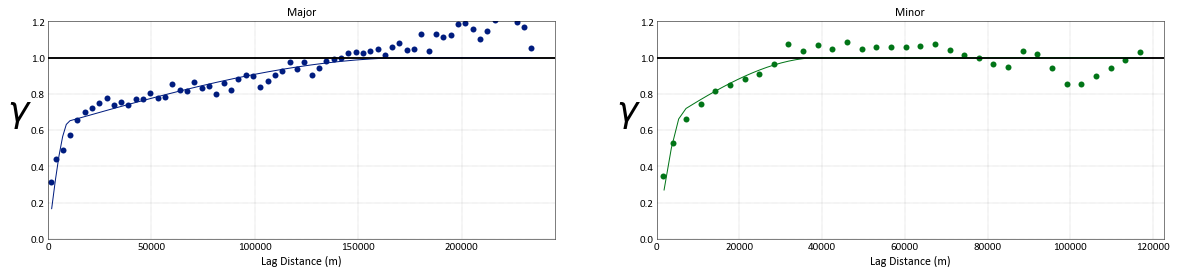

In [ ]:
fig, axes = plt.subplots(1, n_directions, figsize= (20,4))
for i in range(n_directions):
    gs.variogram_plot(varfl, index=i+1, ax = axes[i], color=colors[i], title = titles[i], grid=True)
    gs.variogram_plot(varmdl, index=i+1, ax = axes[i], color=colors[i], experimental=False)

# Kriging

In [ ]:
print(dfl.infergriddef(nblk=[200,200,1]))

200 595.0 1200.0 
200 1170.0 2350.0 
1 0.5 1.0


In [ ]:
kt3dn = gs.Program(exe_dir+'kt3dn', getpar=True)

C:\Users\yimin\Desktop\temp\pygeostat\pygeostat_public\examples\tmp2f7p685r\kt3dn.par has been copied to the clipboard


In [ ]:
parstr_ = """     Parameters for KT3DN
                 ********************
START OF PARAMETERS:
{file}                                -file with data
0  1 2 0 3 0    -  columns for DH,X,Y,Z,var,sec var
{t_min}    1.0e21                     -  trimming limits
0                                     -option: 0=grid, 1=cross, 2=jackknife
nojack.out                           -file with jackknife data
0 0 0 0   0                          -   columns for X,Y,Z,vr and sec var
kt3dn_dataspacing.out                 -data spacing analysis output file (see note)
1    20.0                             -  number to search (0 for no dataspacing analysis, rec. 10 or 20) and composite length
0    100   0                          -debugging level: 0,3,5,10; max data for GSKV;output total weight of each data?(0=no,1=yes)
kt3dn.dbg-nkt3dn.sum                  -file for debugging output (see note)
{output}                              -file for kriged output (see GSB note)
{griddef}
1    1      1                         -x,y and z block discretization
20    80    12    1                    -min, max data for kriging,upper max for ASO,ASO incr
0      0                              -max per octant, max per drillhole (0-> not used)
200000.0  150000.0  150.0                   -maximum search radii
 0.0   0.0   0.0                      -angles for search ellipsoid
1                                     -0=SK,1=OK,2=LVM(resid),3=LVM((1-w)*m(u))),4=colo,5=exdrift,6=ICCK
0.0 0.6  0.8                          -  mean (if 0,4,5,6), corr. (if 4 or 6), var. reduction factor (if 4)
0 0 0 0 0 0 0 0 0                     -drift: x,y,z,xx,yy,zz,xy,xz,zy
0                                     -0, variable; 1, estimate trend
extdrift.out                          -gridded file with drift/mean
4                                     -  column number in gridded file
keyout.out                            -gridded file with keyout (see note)
0    1                                -  column (0 if no keyout) and value to keep
{varmodel}
"""



krig_output = os.path.join(outdir, 'KrigGrid.out')
                      
with open(os.path.join(outdir,'varmodelfit.out'), 'r') as f:
    varmodel_ = f.readlines()
varmodel = ''''''
for line in varmodel_:
    varmodel += line


parstr=parstr_.format(file=dfl.flname,
                     t_min = gs.Parameters['data.tmin'],
                      griddef = str(dfl.griddef),
                     varmodel=varmodel,
                     output=krig_output)
kt3dn.run(parstr=parstr, liveoutput=True)

Calling:  ['../pygeostat/executable/kt3dn', 'temp']

 KT3DN Version: 7.4.1

  data file = C:\Users\yimin\Anaconda3\envs\pygeostat\
  columns =            0           1           2           0           3
           0
  trimming limits =   -998.000000000000       1.000000000000000E+021
  kriging option =            0
  jackknife data file = nojack.out                              
  columns =            0           0           0           0           0
  data spacing analysis output file = kt3dn_dataspacing.out                   
  debugging level =            0
  summary only file = kt3dn.sum                               
  debugging file = kt3dn.dbg                               
  GSLIB-style output file = Output\KrigGrid.out                     
  nx, xmn, xsiz =          200   595.000000000000        1200.00000000000     
  ny, ymn, ysiz =          200   1170.00000000000        2350.00000000000     
  nz, zmn, zsiz =            1  0.500000000000000        1.00000000000000     
  b

In [ ]:
krigfl = gs.DataFile(krig_output, griddef=dfl.griddef)
krigfl.head()

,Estimate,EstimationVariance
0,0.648362,0.469234
1,0.537988,0.333704
2,0.682902,0.190089
3,2.061108,0.196902
4,2.244650,0.324693


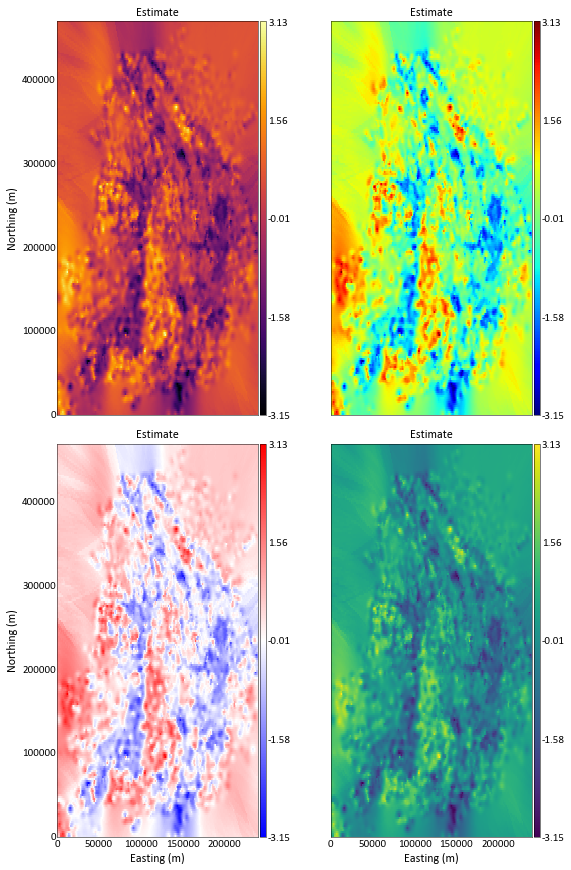

In [ ]:
cmaps = ['inferno', 'jet', 'bwr', 'viridis']
fig, axes = gs.subplots(2, 2, axes_pad=(0.9, 0.4), figsize= (20,15), cbar_mode='each', label_mode='L')
for i, ax in enumerate(axes):
    gs.slice_plot(krigfl, var='Estimate', orient='xy', cmap=cmaps[i], ax=ax)

In [ ]:
# Clean up
try:
    gs.rmfile('kt3dn.sum')
    gs.rmfile('kt3dn.dbg')
    gs.rmfile('kt3dn_dataspacing.out')
    gs.rmfile('temp')
    gs.rmdir(outdir)
except:
    pass